<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#KNN-Model-Construction" data-toc-modified-id="KNN-Model-Construction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>KNN Model Construction</a></span><ul class="toc-item"><li><span><a href="#Implementing-CID" data-toc-modified-id="Implementing-CID-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Implementing CID</a></span><ul class="toc-item"><li><span><a href="#Optimization-with-Numba" data-toc-modified-id="Optimization-with-Numba-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Optimization with Numba</a></span></li></ul></li><li><span><a href="#Feature-Engineering-through-Normalization" data-toc-modified-id="Feature-Engineering-through-Normalization-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature Engineering through Normalization</a></span></li><li><span><a href="#Other-Helper-Functions" data-toc-modified-id="Other-Helper-Functions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Other Helper Functions</a></span></li></ul></li><li><span><a href="#Model-Implementation" data-toc-modified-id="Model-Implementation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Implementation</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-Optimization" data-toc-modified-id="Hyperparameter-Optimization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Hyperparameter Optimization</a></span></li></ul></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#Metrics" data-toc-modified-id="Metrics-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Metrics</a></span></li><li><span><a href="#Distance-Metric-Evaluation" data-toc-modified-id="Distance-Metric-Evaluation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Distance Metric Evaluation</a></span></li><li><span><a href="#Prediction-Evaluation" data-toc-modified-id="Prediction-Evaluation-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Prediction Evaluation</a></span></li><li><span><a href="#Metric-Analysis" data-toc-modified-id="Metric-Analysis-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Metric Analysis</a></span><ul class="toc-item"><li><span><a href="#By-Security" data-toc-modified-id="By-Security-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>By Security</a></span></li><li><span><a href="#Security-Volatility-Relationship" data-toc-modified-id="Security-Volatility-Relationship-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>Security Volatility Relationship</a></span></li><li><span><a href="#Security-Autocorrelation-Relationship" data-toc-modified-id="Security-Autocorrelation-Relationship-5.4.3"><span class="toc-item-num">5.4.3&nbsp;&nbsp;</span>Security Autocorrelation Relationship</a></span></li></ul></li></ul></li><li><span><a href="#Discussion-and-Next-Steps" data-toc-modified-id="Discussion-and-Next-Steps-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Discussion and Next Steps</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
from sklearn.neighbors import KNeighborsRegressor

In [3]:
total_df = pd.read_csv('Data/TimeSeries.csv')

def generate_ts(symbol):
    time_series = total_df[total_df['security'] == symbol]
    time_series = time_series.set_index('date').sort_index(ascending=True)['value']
    time_series = pd.to_numeric(time_series)
    time_series.index = pd.to_datetime(time_series.index)
    return time_series

# KNN Model Construction

## Implementing CID

### Optimization with Numba

## Feature Engineering through Normalization

## Other Helper Functions

In [4]:
class TimeSeriesKNN():

    def __init__(self, time_series, metric=None, k=5, length=5, step=1):
        self.ts = time_series
        self.k = k
        self.length = length
        self.step = step
        if metric is None:
            self.model = KNeighborsRegressor(algorithm='brute')
        else:
            self.model = KNeighborsRegressor(
                algorithm='brute', metric=self.cid)

    @staticmethod
    @jit
    def cid(x, y):
        x = x.astype(np.float64)
        y = y.astype(np.float64)
        x_diff = np.diff(x)
        y_diff = np.diff(y)
        ce_x = np.sqrt(x_diff.dot(x_diff))
        ce_y = np.sqrt(y_diff.dot(y_diff))
        ces = np.asarray([ce_x, ce_y])
        ce = np.max(ces)/np.min(ces)
        return np.linalg.norm(x-y) * ce

    def normalize_series(self, length=None, step_ahead=None, time_series=None):
        if length is None:
            length = self.length
        if step_ahead is None:
            step_ahead = self.step
        if time_series is None:
            time_series = self.ts
        sub_cols = ['ts_' + str(l) for l in range(length)]
        x_cols = ['z_' + str(l) for l in range(length)]
        df = pd.concat([time_series.shift(l).rename(sub_cols[l])
                        for l in range(length)], axis=1)
        df['actual'] = df[sub_cols[0]].shift(-step_ahead)
        df['mean'] = df[sub_cols].mean(axis=1)
        df['std'] = df[sub_cols].std(axis=1)
        df = pd.concat([df, pd.concat([df[sub_cols[l]].subtract(df['mean']).div(
            df['std']).rename(x_cols[l]) for l in range(length)], axis=1)], axis=1)
        df['actual_z'] = df['actual'].subtract(df['mean']).div(df['std'])
        y_col = 'actual_z'
        df = df.iloc[length-1:]
        df = df[df['std'] != 0]
        return df, x_cols, y_col

    def predict(self, model, train_y, test_x, x_mean, x_std, k):
        locs = model.kneighbors(np.reshape(
            test_x.to_numpy(), (1, -1)), n_neighbors=k, return_distance=False)
        neighbors = pd.concat([train_y.iloc[row] for row in locs])
        prediction = np.mean((neighbors*x_std + x_mean))
        return prediction

    def predict_history(self, start=1000, step=None, length=None, k=None):
        if step is None:
            step = self.step
        if length is None:
            length = self.length
        if k is None:
            k = self.k
        model = self.model
        ml_set, x_cols, y_col = self.normalize_series(length, step)
        prediction_list = []

        for i in range(len(ml_set)-start-step+1):
            #print('Test {} of {}'.format(i, (len(ml_set)-start)))
            train = ml_set.iloc[:min([start+i-step+1, len(ml_set)-step])]
            test = ml_set.iloc[start+i+step-1]
            model.fit(train[x_cols], train[y_col])
            prediction_list.append(
                self.predict(model, train[y_col], test[x_cols], test['mean'], test['std'], k))
        pred_series = pd.Series(data=prediction_list,
                                index=ml_set.iloc[start+step-1:].index)
        values = pd.concat([ml_set, pred_series.rename(
            'prediction')], axis=1, join='outer')
        values = values[['ts_0', 'actual', 'prediction']].shift(step)
        values = values.rename(columns={'ts_0': 'actual_prev'})
        values['actual_return'] = 100 * \
            (values['actual'].div(values['actual_prev'])-1)
        values['predicted_return'] = 100 * \
            (values['prediction'].div(values['actual_prev'])-1)
        return values.dropna(axis=0, how='any')

    def predict_next(self, date=None, horizon=None, length=None, k=None):
        if length is None:
            length = self.length
        if k is None:
            k = self.k
        if horizon is None:
            horizon = 90
        if date is None:
            date = self.ts.index[-91]
            index = self.ts.index[-90:]
        elif pd.to_datetime(date) >= self.ts.index[-horizon]:
            index = pd.bdate_range(
                start=date + pd.tseries.offsets.BDay(1), periods=horizon)
        elif pd.to_datetime(date) < self.ts.index[-horizon]:
            date = self.ts.index[self.ts.index >= date].min()
            index = self.ts.index[self.ts.index > date][:horizon]

        model = self.model

        prediction_list = []
        history = self.ts[self.ts.index <= date]

        for i in range(horizon):
            ml_set, x_cols, y_col = self.normalize_series(
                length=length, step_ahead=i+1, time_series=history)
            train = ml_set.iloc[:len(ml_set)-i-1]
            test = ml_set.iloc[-1]
            model.fit(train[x_cols], train[y_col])
            prediction_list.append(self.predict(
                model, train[y_col], test[x_cols], test['mean'], test['std'], k))
        pred_series = pd.Series(data=prediction_list,
                                index=index, name='prediction')
        values = pd.merge(pred_series, self.ts.rename(
            'actual'), how='left', left_index=True, right_index=True)

        return values[['actual', 'prediction']]

    def get_metrics(self, values):
        metrics = {}
        values['error'] = values['actual']-values['prediction']
        values['error_return'] = values['actual_return']-values['predicted_return']
        values['naive'] = values['actual']-values['actual_prev']
        metrics['mse'] = values['error'].pow(2).mean()
        metrics['tu'] = (values['error'].pow(
            2).sum())/(values['naive'].pow(2).sum())
        metrics['mase'] = (values['error'].abs().mean())/(values['naive'].abs().mean())
        metrics['mape'] = (values['error']/values['actual']).abs().mean()*100
        metrics['rmse_return'] = np.sqrt(values['error_return'].pow(2).mean())
        metrics['nrmse_return'] = metrics['rmse_return']/(np.abs(values['actual_return'].abs().mean()))
        
        tp = len(values[(values['actual_return']>0) & (values['predicted_return']>0)])
        tn = len(values[(values['actual_return']<0) & (values['predicted_return']<0)])
        fp = len(values[(values['actual_return']<0) & (values['predicted_return']>0)])
        fn = len(values[(values['actual_return']>0) & (values['predicted_return']<0)])
        
        metrics['accuracy'] = (tp+tn)/(tp+tn+fp+fn)
        metrics['precision'] = tp/(tp+fp)
        metrics['recall'] = tp/(tp+fn)
        metrics['fscore'] = (2*metrics['precision']*metrics['recall'])/(metrics['precision']+metrics['recall'])
        
        return metrics
    
    def evaluate_model(self, start=None, step=None, length=None, k=None):
        if start is None:
            start = round(len(self.ts)*.5)
        if step is None:
            step=self.step
        if length is None:
            length = self.length
        if k is None:
            k=self.k
        metrics = self.get_metrics(self.predict_history(start=start, step=step, length=length, k=k))

        
        return metrics

# Model Implementation

## Hyperparameter Optimization

In [14]:
CFG = {
    'length': [5,10,15,20],
    'step_ahead': 1,
    'k': [5,10,25,50,75,100,125]
}

time_series = generate_ts('SPY')

knn_model = TimeSeriesKNN(time_series,metric='cid')

l_mse = {}

for length in CFG['length']:
    print('Evaluating length parameter: {}'.format(length))
    k_mse = {}
    for k in CFG['k']:
        print('\tEvaluating k parameter: {}'.format(k))
        metrics = knn_model.evaluate_model(step=CFG['step_ahead'], length=length, k=k)
        k_mse[k] = metrics['mse']
    l_mse[length] = k_mse

Evaluating length 5...
Evaluating k 5...
Evaluating k 10...
Evaluating k 25...
Evaluating k 50...
Evaluating k 75...
Evaluating k 100...
Evaluating k 125...
Evaluating length 10...
Evaluating k 5...
Evaluating k 10...
Evaluating k 25...
Evaluating k 50...
Evaluating k 75...
Evaluating k 100...
Evaluating k 125...
Evaluating length 15...
Evaluating k 5...
Evaluating k 10...
Evaluating k 25...
Evaluating k 50...
Evaluating k 75...
Evaluating k 100...
Evaluating k 125...
Evaluating length 20...
Evaluating k 5...
Evaluating k 10...
Evaluating k 25...
Evaluating k 50...
Evaluating k 75...
Evaluating k 100...
Evaluating k 125...


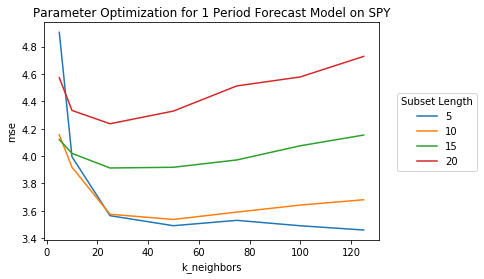

subset_length,5,10,15,20
k_neighbors,,,,
5,4.905449,4.156027,4.120786,4.573474
10,3.995087,3.918725,4.019886,4.334218
25,3.564014,3.574387,3.913017,4.236637
50,3.490841,3.536630,3.918262,4.329522
75,3.529959,3.590276,3.971841,4.513520
100,3.490431,3.641707,4.075448,4.578990
125,3.459280,3.680612,4.153970,4.729425


In [34]:
mse_data = pd.DataFrame(data=l_mse)
mse_data.index = mse_data.index.rename('k_neighbors')
mse_data.columns = mse_data.columns.rename('subset_length')
mse_data.plot()
plt.ylabel('mse')
plt.legend(bbox_to_anchor=(1.04,.7), title='Subset Length')
plt.title('Parameter Optimization for 1 Period Forecast Model on SPY')
plt.show()
mse_data
#SPY_param_mse.csv

# Model Evaluation

## Metrics

## Distance Metric Evaluation

In [38]:
CFG_set = {
    'length': 5,
    'step_ahead': 1,
    'k': 125
}

cid_metrics = {}
ed_metrics = {}

for security in np.random.choice(total_df['security'].unique(),size = 10):
    time_series = generate_ts(security)
    knn_cid = TimeSeriesKNN(time_series,metric='cid')
    knn_ed = TimeSeriesKNN(time_series)
    cid_metrics[security] = knn_cid.evaluate_model(step=CFG_set['step_ahead'], length=CFG_set['length'], k=CFG_set['k'])
    ed_metrics[security] = knn_ed.evaluate_model(step=CFG_set['step_ahead'], length=CFG_set['length'], k=CFG_set['k'])

In [42]:
cid_data = pd.DataFrame(data = cid_metrics)
ed_data = pd.DataFrame(data = ed_metrics)

In [74]:
mse_comp = pd.concat([ed_data.loc['mse'].rename('Euc'),cid_data.loc['mse'].rename('CID')],axis=1)
mse_comp.style.highlight_min(axis = 1)

,Euc,CID
ABT,0.362135,0.358342
BAC,0.101716,0.101902
USB,0.228064,0.227935
LQD,0.125844,0.125883
VTI,0.957828,0.959041
MRK,0.403422,0.405805
NEE,1.724477,1.729216
IJH,1.991043,1.975248


In [64]:
tu_comp = pd.concat([ed_data.loc['tu'].rename('Euc'),cid_data.loc['tu'].rename('CID')],axis=1)
tu_comp.style.highlight_min(axis = 1)

,Euc,CID
ABT,1.000985,0.990503
BAC,1.019650,1.021514
USB,1.028050,1.027469
LQD,1.007309,1.007620
VTI,1.014733,1.016018
MRK,1.019078,1.025097
NEE,1.015666,1.018457
IJH,1.028374,1.020216


In [65]:
mase_comp = pd.concat([ed_data.loc['mase'].rename('Euc'),cid_data.loc['mase'].rename('CID')],axis=1)
mase_comp.style.highlight_min(axis = 1)

,Euc,CID
ABT,1.011867,1.005645
BAC,1.009044,1.006310
USB,1.008726,1.011337
LQD,0.995333,0.993856
VTI,1.010861,1.008509
MRK,1.011515,1.015018
NEE,1.008786,1.008984
IJH,1.007454,1.005659


In [72]:
mape_comp = pd.concat([ed_data.loc['mape'].rename('Euc'),cid_data.loc['mape'].rename('CID')],axis=1)
mape_comp.style.highlight_min(axis = 1)

,Euc,CID
ABT,0.877770,0.874851
BAC,1.437035,1.433542
USB,0.958169,0.962109
LQD,0.249391,0.248959
VTI,0.659348,0.657458
MRK,0.887265,0.890859
NEE,0.769421,0.770027
IJH,0.777706,0.776174


In [67]:
nrmse_comp = pd.concat([ed_data.loc['nrmse_return'].rename('Euc'),cid_data.loc['nrmse_return'].rename('CID')],axis=1)
nrmse_comp.style.highlight_min(axis = 1)

,Euc,CID
ABT,1.412812,1.409766
BAC,1.476294,1.474218
USB,1.450673,1.451945
LQD,1.366085,1.364802
VTI,1.487348,1.484226
MRK,1.407756,1.414664
NEE,1.374164,1.375638
IJH,1.439424,1.430922


In [73]:
acc_comp = pd.concat([ed_data.loc['accuracy'].rename('Euc'),cid_data.loc['accuracy'].rename('CID')],axis=1)
acc_comp.style.highlight_max(axis = 1).format("{:.2%}")

,Euc,CID
ABT,51.53%,51.69%
BAC,50.14%,50.22%
USB,52.35%,51.87%
LQD,53.50%,54.65%
VTI,50.28%,50.58%
MRK,49.72%,50.24%
NEE,51.80%,51.60%
IJH,48.69%,51.23%


In [70]:
fscore_comp = pd.concat([ed_data.loc['fscore'].rename('Euc'),cid_data.loc['fscore'].rename('CID')],axis=1)
fscore_comp.style.highlight_max(axis = 1)

,Euc,CID
ABT,0.567519,0.565202
BAC,0.509193,0.517703
USB,0.573794,0.568543
LQD,0.638661,0.650177
VTI,0.561113,0.568452
MRK,0.515304,0.521268
NEE,0.612416,0.608668
IJH,0.546233,0.574348


## Prediction Evaluation

In [111]:
CFG_test = {
    'length': 5,
    'step_ahead': [1, 5, 10, 30, 60],
    'k': 125
}

security_metrics = {}

filter_data = total_df.groupby('security').filter(lambda x: len(x) > 250)

for security in toprocess:
    time_series = generate_ts(security)
    knn_model = TimeSeriesKNN(time_series, metric='cid')
    print('Evaluating predictions on {}...'.format(security))
    step_metrics = {}
    for step in CFG_test['step_ahead']:
        print('\t{} periods in the future...'.format(step))
        step_metrics[step] = knn_model.evaluate_model(
            step=step, length=CFG_test['length'], k=CFG_test['k'])
    security_metrics[security] = step_metrics

Evaluating predictions on DHR...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on DIS...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on DUK...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on EFA...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on EMR...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on EXC...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	3

	30 periods in the future...
	60 periods in the future...
Evaluating predictions on MS...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on NEE...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on NFLX...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on NKE...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on NVDA...
	1 periods in the future...
	5 periods in the future...
	10 periods in the future...
	30 periods in the future...
	60 periods in the future...
Evaluating predictions on ORCL...
	1 periods in the future...

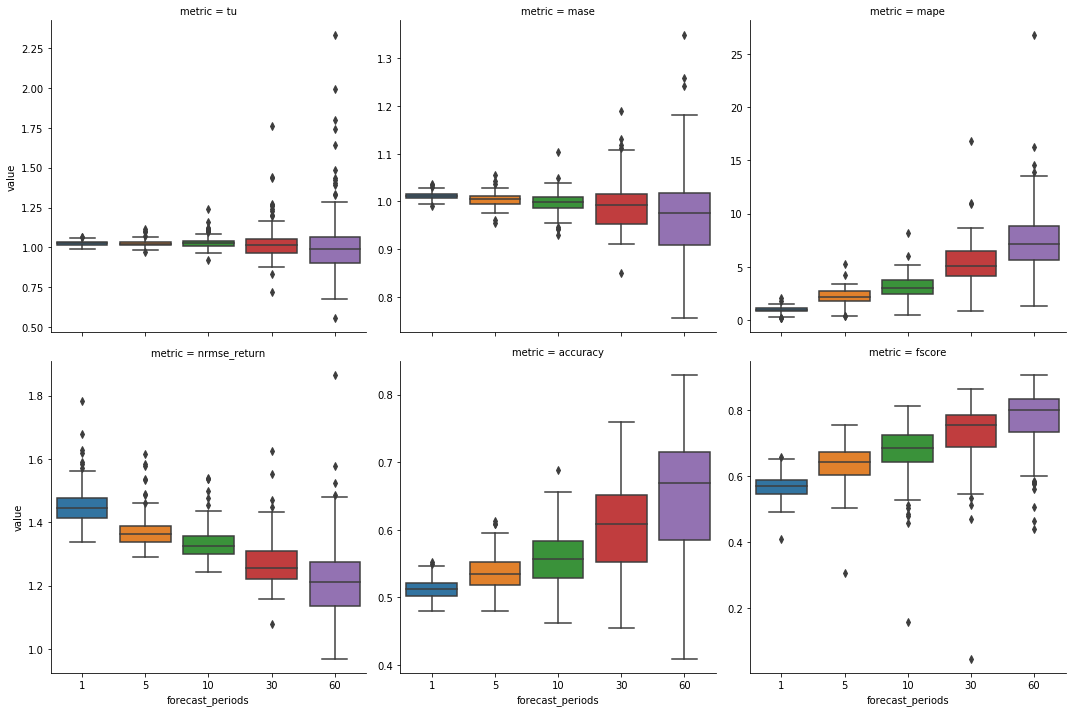

In [8]:
sec_metrics = pd.read_csv('Data\security_metrics.csv')
secmetgraph = sec_metrics[['security','forecast_periods','tu','mase','mape','nrmse_return','accuracy','fscore']]
graph_data = secmetgraph.melt(id_vars=['security','forecast_periods'],var_name='metric')

g = sns.catplot(x='forecast_periods', y='value', col='metric',
               data=graph_data, kind='box', col_wrap=3, sharey=False)
plt.savefig('metric_graph.png')

## Metric Analysis

### By Security

In [34]:
metric_list = ['tu','mase','mape','nrmse_return','accuracy','fscore']

sec_names = total_df[['security','name']].drop_duplicates()

metrics_names = sec_metrics.merge(sec_names,how='left',left_on='security',right_on='security')

top_list = []

for metric in metric_list:
    top_metric = {}
    for period in [1,5,10,30,60]:
        sorted_met = metrics_names[metrics_names['forecast_periods'] == period][['name',metric]].sort_values(by=metric)
        if metric in [['accuracy','fscore']]:
            top_metric[period] = sorted_met.tail(5)
        else:
            top_metric[period] = sorted_met.head(5)
    metric_df = pd.concat(top_metric, names = ['forecast_period','index'])
    metric_df.index = metric_df.index.droplevel(1)
    top_list.append(metric_df)
    
all_top = pd.concat(top_list,axis=0)
all_top['name'].value_counts().head(10)

NextEra Energy                                         11
Vanguard Total Bond Market ETF                          9
Visa Inc.                                               8
iShares Edge MSCI Min Vol USA ETF                       8
iShares Core U.S. Aggregate Bond ETF                    8
Vanguard Intermediate-Term Corporate Bond ETF           7
Vanguard Growth ETF                                     7
iShares iBoxx $ Investment Grade Corporate Bond ETF     6
Kraft Heinz                                             6
Ford Motor Company                                      6
Name: name, dtype: int64

### Security Volatility Relationship

In [70]:
returns = total_df.groupby('security')['value'].apply(lambda x:(x/x.shift(1)-1))
total_df_returns = total_df.merge(returns,how='left',left_index=True,right_index=True)
vols = total_df_returns.groupby(['security','name'])['value_y'].std()*np.sqrt(252)
vols.sort_values().head(30)

security  name                                               
BND       Vanguard Total Bond Market ETF                         0.044437
VCIT      Vanguard Intermediate-Term Corporate Bond ETF          0.044776
AGG       iShares Core U.S. Aggregate Bond ETF                   0.046664
LQD       iShares iBoxx $ Investment Grade Corporate Bond ETF    0.076159
USMV      iShares Edge MSCI Min Vol USA ETF                      0.112810
IEFA      iShares Core MSCI EAFE ETF                             0.144903
VOO       Vanguard S&P 500 ETF                                   0.150369
VIG       Vanguard Dividend Appreciation ETF                     0.168608
IEMG      iShares Core MSCI Emerging Markets ETF                 0.180674
GLD       SPDR Gold Trust                                        0.181694
VUG       Vanguard Growth ETF                                    0.183157
VTI       Vanguard Total Stock Market ETF                        0.187324
IVV       iShares Core S&P 500 ETF                

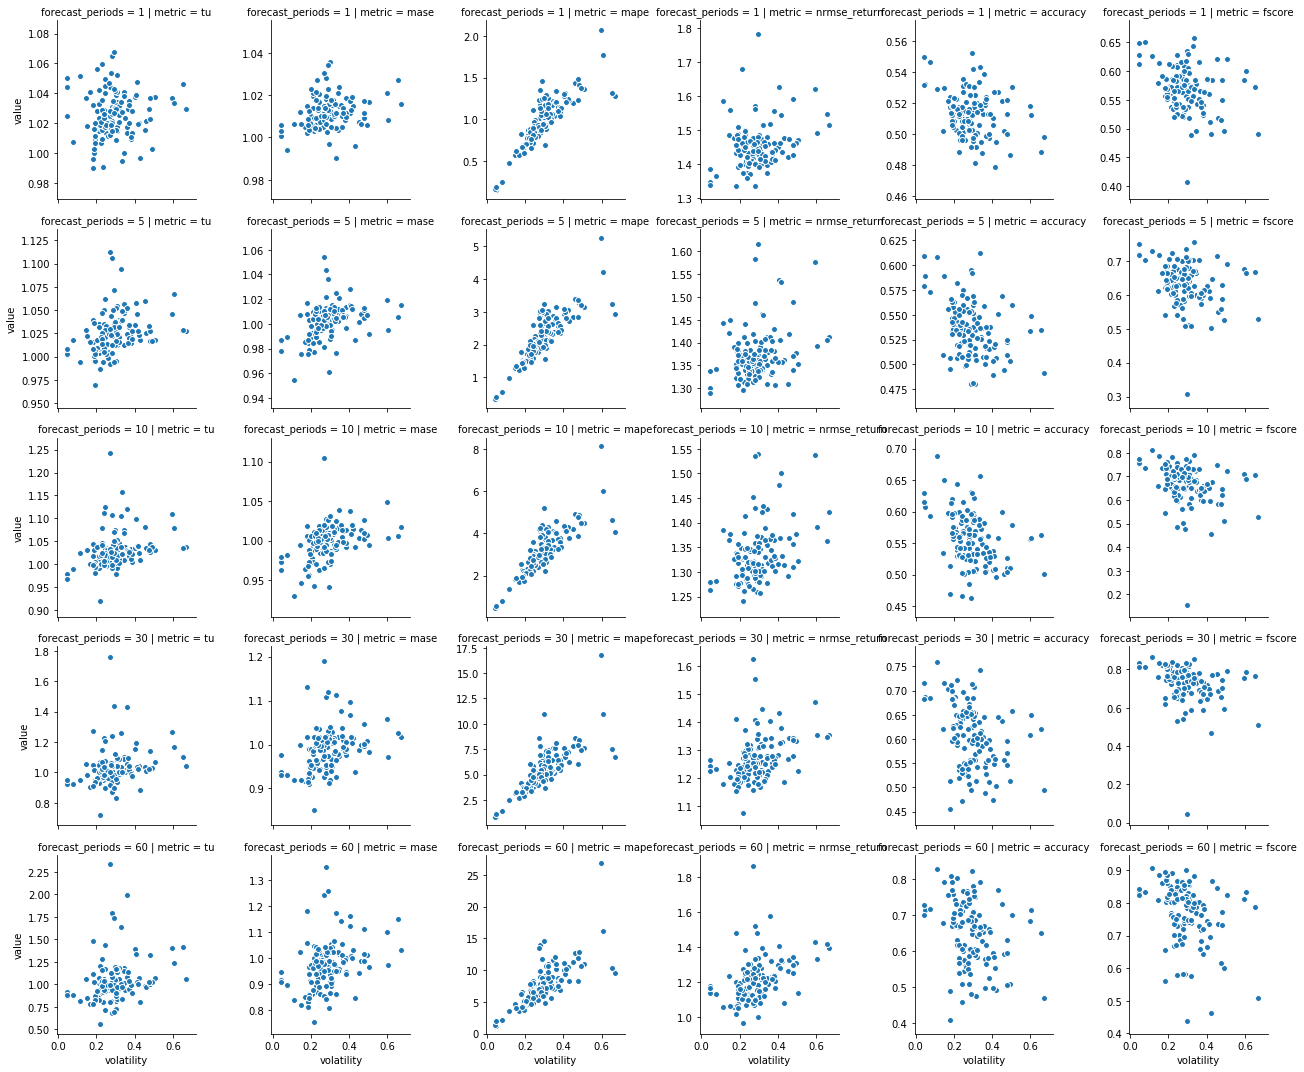

In [106]:
graph_data_vol = graph_data.merge(vols,how='left',left_on='security',right_on='security').rename(columns={'value_y':'volatility'})
g = sns.FacetGrid(graph_data_vol, col='metric',  row='forecast_periods', sharey=False)
g = g.map(plt.scatter, 'volatility', 'value', edgecolor= 'w')

In [61]:
vol_metric_corr = graph_data_vol.groupby(['forecast_periods','metric'])[['value','volatility']].corr()

df_list = []
for metric in metric_list:
    corr_series = vol_metric_corr.xs((metric,'volatility'),level=('metric',2))['value']
    corr_series.name = metric
    df_list.append(corr_series)
corrs = pd.concat(df_list,axis=1)
corrs

,tu,mase,mape,nrmse_return,accuracy,fscore
forecast_periods,,,,,,
1,0.064779,0.244426,0.863321,0.282495,-0.266399,-0.270003
5,0.324558,0.362837,0.859573,0.290452,-0.339241,-0.258659
10,0.332773,0.432174,0.842150,0.375024,-0.344387,-0.275095
30,0.265587,0.320452,0.781157,0.367446,-0.340372,-0.273251
60,0.267601,0.336246,0.750577,0.393987,-0.300578,-0.312039


### Security Autocorrelation Relationship

In [103]:
df_list = []

for period in [1, 5, 10, 30, 60]:
    autocorr = total_df.groupby('security')['value'].apply(
        pd.Series.autocorr, lag=period).rename(period)
    df_list.append(autocorr)

ac_df = pd.concat(df_list, axis=1)
(ac_df.rank(axis=0)/len(ac_df)).loc['NEE']

1     0.984127
5     0.976190
10    0.984127
30    0.992063
60    1.000000
Name: NEE, dtype: float64

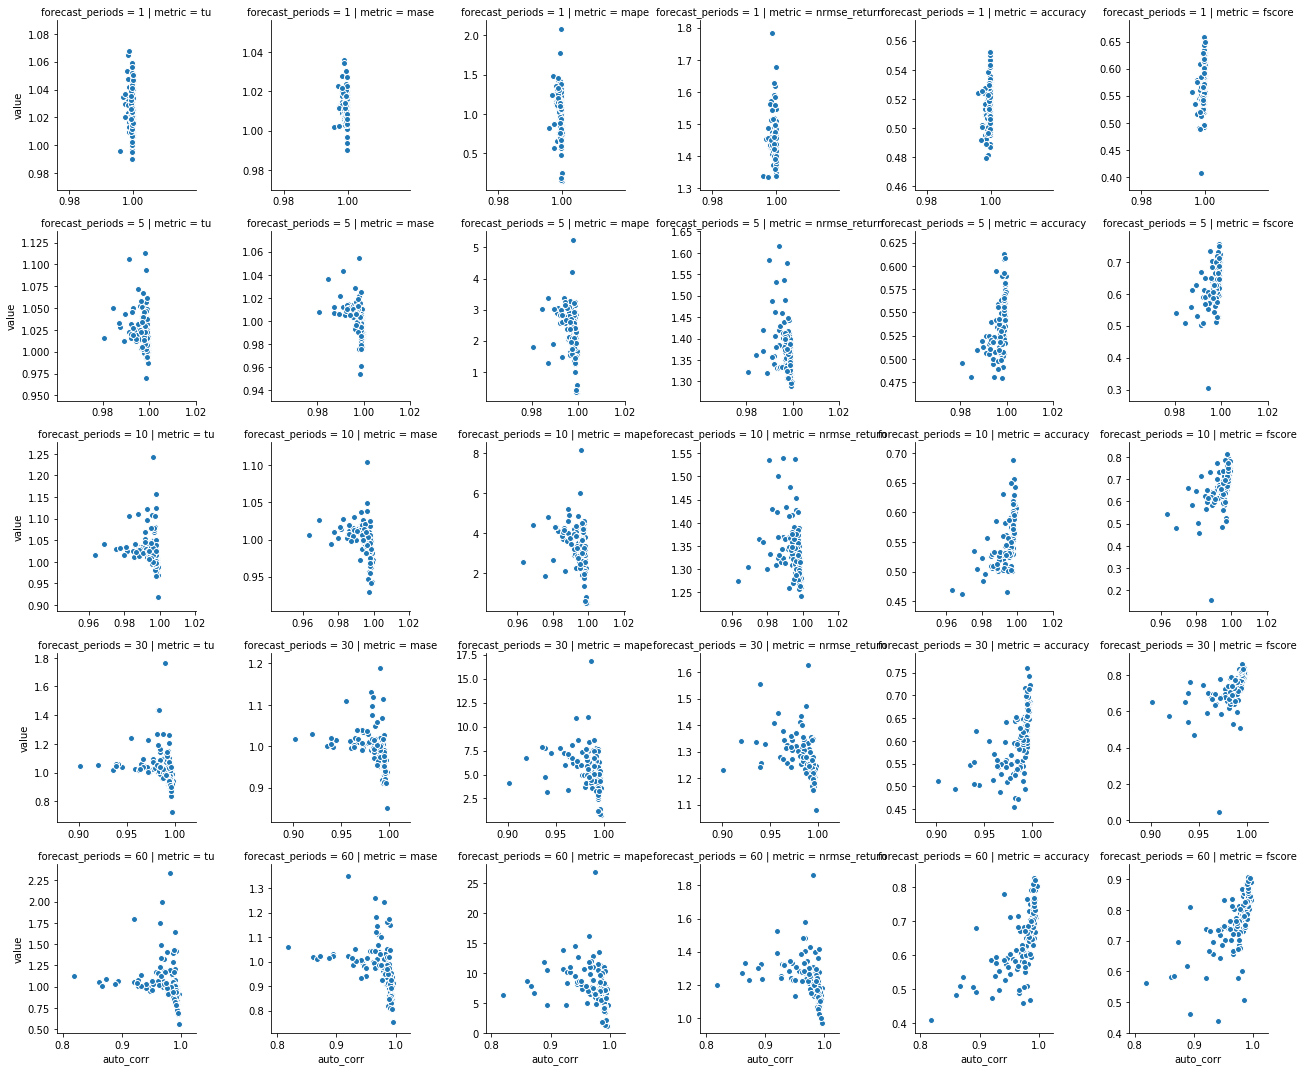

In [104]:
ac_df_unpivot = ac_df.reset_index().melt(
    id_vars='security', var_name='forecast_periods', value_name='auto_corr')

graph_data_ac = graph_data.merge(ac_df_unpivot, how='left', left_on=[
                                 'security', 'forecast_periods'], right_on=['security', 'forecast_periods'])
g = sns.FacetGrid(graph_data_ac, col='metric',
                  row='forecast_periods', sharey=False, sharex=False)
g = g.map(plt.scatter, 'auto_corr', 'value', edgecolor='w')

In [95]:
vol_metric_ac = graph_data_ac.groupby(['forecast_periods','metric'])[['value','auto_corr']].corr()

df_list = []
for metric in metric_list:
    corr_series = vol_metric_ac.xs((metric,'auto_corr'),level=('metric',2))['value']
    corr_series.name = metric
    df_list.append(corr_series)
corrs = pd.concat(df_list,axis=1)
corrs

,tu,mase,mape,nrmse_return,accuracy,fscore
forecast_periods,,,,,,
1,-0.036724,-0.163649,-0.261149,-0.059428,0.213723,0.348566
5,-0.185539,-0.434265,-0.291232,-0.260854,0.485072,0.502151
10,-0.129176,-0.349209,-0.298919,-0.255466,0.573340,0.526696
30,-0.196383,-0.369384,-0.277768,-0.412651,0.562292,0.491416
60,-0.204842,-0.382849,-0.264944,-0.367392,0.639628,0.666670


# Discussion and Next Steps

# References